In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

log_path = ''

In [101]:
df = pd.read_csv('Data/amazon_fashion.csv', names=['item','user','rating'])
df.head()

,item,user,rating
0,7106116521,A1D4G1SNUZWQOT,5.0
1,7106116521,A3DDWDH9PX2YX2,2.0
2,7106116521,A2MWC41EW7XL15,4.0
3,7106116521,A2UH2QQ275NV45,2.0
4,7106116521,A89F3LQADZBS5,3.0


In [102]:
df['rating'] = df['rating'].astype(int)

# Data Exploration

First filtering active users and rated items with x or more ratings:

In [103]:
item_thres = 1
user_thres = 1

In [104]:
df['#ratings'] = df.groupby('item')['item'].transform('count')
df = df[df['#ratings'] >= item_thres].drop(columns=['#ratings'])

df['#ratings'] = df.groupby('user')['user'].transform('count')
df = df[df['#ratings'] >= user_thres].drop(columns=['#ratings'])

In [105]:
norpu = df.groupby('user')['rating'].count().mean()
total_users = df.user.unique().size
total_items = df.item.unique().size

In [106]:
df = df.sample(frac=0.1, random_state=1234)

rows  88364 
#ratings 88364 
#ratings/user 1.18 
average rating 3.91 
#users  86273 
#items  42660


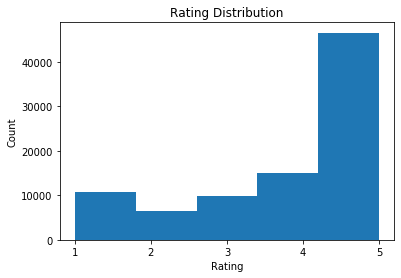

In [107]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size)
df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1,6))
plt.show()

# Data Prep & Split (Numpy)
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [108]:
items = df['item'].unique()
itemsDF = pd.DataFrame(data=items, columns=['original_item_id'])
itemsDF['new_item_id'] = itemsDF.index

users = df['user'].unique()
usersDF = pd.DataFrame(data=users, columns=['original_user_id'])
usersDF['new_user_id'] = usersDF.index

ratingDF = df.merge(itemsDF, left_on='item', right_on='original_item_id')
ratingDF = ratingDF.drop(columns=['original_item_id'])

ratingDF = ratingDF.merge(usersDF, left_on='user', right_on='original_user_id')
ratingDF = ratingDF.drop(columns=['original_user_id'])

df_new_ids = ratingDF
total_users = df_new_ids.user.unique().size
total_items = df_new_ids.item.unique().size
print('Full data #row: ', df_new_ids.shape[0], '\n#users: ', total_users, '\n#items: ', total_items)
df_new_ids.head()

Full data #row:  88364 
#users:  86273 
#items:  42660


,item,user,rating,new_item_id,new_user_id
0,B00JVZNFD4,A26KB3UU8QHM3U,4,0,0
1,B00H8AG1WQ,A2WAE4OCVH2WVX,1,1,1
2,B00H8AG1WQ,A3L0NFW61XD046,3,1,10544
3,B00H8AG1WQ,APBFKY94679MJ,5,1,13982
4,B00H8AG1WQ,A2367FDV1RKCER,5,1,17264


### Train Test split
Train 0.9, Test 0.1, could add validation set

In [109]:
X_train, X_test = train_test_split(df_new_ids, test_size=0.20, shuffle=True, random_state=1234)
X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=1234)

print('Size of train set: ', len(X_train))
print('Size of validation set: ', len(X_validation))
print('Size of test set: ', len(X_test))

Size of train set:  70691
Size of validation set:  8836
Size of test set:  8837


In [110]:
X_train

,item,user,rating,new_item_id,new_user_id
57893,B000S5WNXO,A2MQC0W3SMA3OV,5,17017,26944
12392,B00NIVAEG8,A3OOHJ2ERK5SPV,2,917,19920
24696,B00KO486SU,A1181K4LPTFQ4J,5,2867,3435
9467,B017NT1F4A,AC42ZXOMLYGKZ,5,548,18525
39710,B00E346HB0,A2UBPK2ZKT8C73,2,7565,10268
...,...,...,...,...,...
32399,B00KBOQTCS,A3W3XQY4GQRSIY,4,4911,27626
82584,B00I9BNB62,ACY140T4MWIC9,1,36898,76294
60620,B00UXZ74KG,AGHOANU3VX1DJ,5,18831,30510
34086,B017425OJS,A2DL96FVT9TBTI,3,5440,48965


### Create user item matrix (sparse format)
Function to put the data in an user x items matrix, users as index, items as columns

In [111]:
def create_matrix(X_train, n_users, n_items):
    n_users = df.user.unique().shape[0]
    n_items = df.item.unique().shape[0]

    r = X_train['new_user_id']
    c = X_train['new_item_id']
    d = X_train['rating']
    train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    print('train matrix shape: ', train_matrix.shape)
    
    return train_matrix

# SVD (PMF)
Building the SVD recommender step by step

Assumptions:
- Time has no influence on the ratings, e.g. could base sampling on most recent ratings or give recent ratings more weight
- Note: Suffers from cold start problem

### Global mean based on variances

In [112]:
# Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
va = X_train.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
vb = X_train.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
k = va/vb #variance proportion
better_mu = (X_train['rating'].mean() + X_train['rating'].sum()) / (k+len(X_train))
print('original_mu:', X_train['rating'].mean(), ' Var based mu:', better_mu)

original_mu: 3.9072442036468575  Var based mu: 3.907239460074022


### Parameters

In [113]:
params = {"nolf":15, #Size of latent feature vectors
"n_epochs":50,

#Learning rate
"alpha":0.004, #Low alpha to prevent diverging => sgd all over the place => error up
"alpha_b":0.004,

"use_bias":True,

#Regularizers, still tweaking the values
"bu_reg":0.5,
"bi_reg":0.5,
"pu_reg":0.001,
"qi_reg":0.001
}

# Training Setup
- Step 1: Creating train_matrix from X_train (not actually used yet)
- Step 2: Put new user id, new item id and corresponding rating from X_train in a tuple
- Step 3: Init params, init bias vectors b_user and b_item to zeros, init matrices p (n_users*nolf) and q (n_items*nolf) at random
- Step 4: Start iterations, keep track of time and rmses
- Step 5: calc error and update p and q using sgd (if use_bias=True, different error update and update biases too with sgd)
- Step 6: Plot RMSE against Epochs and Test algorithm on Test set
- Step 7: Store results in pickle file

### Biases

$ \hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u} $

Where $\mu$ is the overall average

$b_u$ is the users deviation from the overall average,

$b_i$ is the items deviation from the overall averag,

In [114]:
def plot_rmse(rmse, n_epochs):
    plt.plot(np.arange(n_epochs), rmse)
    plt.title('RMSE')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [115]:
def SVD(X_train, params, n_users, n_items, plot = True):

#     train_matrix = create_matrix(X_train, n_users, n_items)
    tuples_train = [tuple(x) for x in X_train[['new_user_id', 'new_item_id', 'rating']].to_numpy()]

    #Init
    nolf = params['nolf']
    n_epochs = params['n_epochs']
    alpha = params['alpha']
    alpha_b = params['alpha_b']
    use_bias = params['use_bias']
    
    bu_reg = params['bu_reg']
    bi_reg = params['bi_reg']
    pu_reg = params['pu_reg']
    qi_reg = params['qi_reg']
    
    b_user = np.zeros(total_users)
    b_item = np.zeros(total_items)

    p = np.random.normal(0,.1,(total_users, nolf)) #users
    q = np.random.normal(0,.1,(total_items, nolf)) #items

    start = time.time()
    rmses = []
    for epoch in range(n_epochs):
        total_sq_error = 0
        for u, i, r_ui in tuples_train:

            if use_bias:
                error = r_ui - ((better_mu + b_user[u] + b_item[i]) + np.dot(p[u], q[i]))
                b_user[u] += alpha_b * (error - bu_reg * b_user[u])
                b_item[i] += alpha_b * (error - bi_reg * b_item[i])
            else:
                error = r_ui - np.dot(p[u], q[i])

            p[u] += alpha * (error * q[i] - pu_reg * p[u])
            q[i] += alpha * (error * p[u] - qi_reg * q[i])
            total_sq_error += np.square(error)
            
        rmse = np.sqrt(total_sq_error/len(tuples_train))
        rmses.append(rmse)
        print('Epoch:', epoch, '  RMSE:', rmse)
    
    if plot:
        plot_rmse(rmses, n_epochs)
    
    t = time.time() - start
    
    return p, q, b_user, b_item, rmses, t

# Testing Setup

In [116]:
def estimate(u, i, p, q, b_user, b_item):
    est = b_user[u] + b_item[i] + better_mu
    if u in X_train['new_user_id'] and i in X_train['new_item_id']:
        est += np.dot(p[u], q[i])
    
    return est

In [117]:
def test(X_test, p, q, b_user, b_item):
    tuples_test = [tuple(x) for x in X_test[['new_user_id', 'new_item_id', 'rating']].to_numpy()]

    total_error = 0
    estimates = []
    for u, i, r_ui in tuples_test:
        est = estimate(u, i, p, q, b_user, b_item)
        estimates.append(est)
        total_error += np.square(r_ui - est)
        
    rmse = np.sqrt(total_error/len(tuples_test))
    print('RMSE: ', rmse)
    return rmse, estimates

# Old Model

In [125]:
class SVD:
    """" All functions used to run, test, plot and store the
    Singular Value Decomposition Model"""

    def __init__(self, params):
        self.nolf = params['nolf']

        self.n_epochs = params['n_epochs']
        self.alpha = params['alpha']
        self.alpha_b = params['alpha_b']
        self.use_bias = params['use_bias']
        self.bu_reg = params['bu_reg']
        self.bi_reg = params['bi_reg']
        self.pu_reg = params['pu_reg']
        self.qi_reg = params['qi_reg']
#         self.random_state = params['random_state']
        self.params = params
        self.mu = 0 #create function to change mu?

        self.train_data = pd.DataFrame()
        self.train_time = 0
        self.model = {}
        self.test_results = {}
        self.test_int = 0

    def fit(self, train_data, total_users, total_items, verbose = 1):
        self.SVD(train_data, total_users, total_items, verbose)
        return self

    def SVD(self, train_data, total_users, total_items, verbose, plot=True):
        """"The SVD algorithm with sgd
        input: rating dataset with columns:['rating', 'user_id', 'item_id']
        output: the resulting p, q, bi, bu matrices"""
        self.train_data = train_data
#         total_users = self.train_data.new_user_id.unique().size
#         total_items = self.train_data.new_item_id.unique().size
        tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]

        b_user = np.zeros(total_users)
        b_item = np.zeros(total_items)

        p = np.random.normal(0, .1, (total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (total_items, self.nolf))  # items

        start = time.time()
        rmses = []
        for epoch in range(self.n_epochs):
            total_sq_error = 0
            for u, i, r_ui in tuples_train:

                if self.use_bias:
                    error = r_ui - ((self.mu + b_user[u] + b_item[i]) + np.dot(p[u], q[i]))
                    b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
                    b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
                else:
                    error = r_ui - np.dot(p[u], q[i])

                p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
                q[i] += self.alpha * (error * p[u] - self.qi_reg * q[i])
                total_sq_error += np.square(error)

            rmse = np.sqrt(total_sq_error / len(tuples_train))
            rmses.append(rmse)
            if epoch % verbose == 0:
                print('Epoch:', epoch, '  RMSE:', rmse)

        if plot:
            self.plot_rmse(rmses)

        self.train_time = time.time() - start

        self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'rmse':rmses}

    def transform_data(self, df):
        """Create new ids for users and items that match the row
        and column indices of the user-item interaction matrix"""
        items = df['item'].unique()
        itemsDF = pd.DataFrame(data=items, columns=['original_item_id'])
        itemsDF['new_item_id'] = itemsDF.index

        users = df['user'].unique()
        usersDF = pd.DataFrame(data=users, columns=['original_user_id'])
        usersDF['new_user_id'] = usersDF.index

        ratingDF = df.merge(itemsDF, left_on='item', right_on='original_item_id')
        ratingDF = ratingDF.drop(columns=['original_item_id'])

        ratingDF = ratingDF.merge(usersDF, left_on='user', right_on='original_user_id')
        ratingDF = ratingDF.drop(columns=['original_user_id'])

        return ratingDF

    def plot_rmse(self,rmse):
        plt.plot(np.arange(self.n_epochs), rmse)
        plt.title('RMSE')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

    def test(self, test_data):
#         test_data = self.transform_data(test_data)
        tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]

        total_error = 0
        estimates = []
        for u, i, r_ui in tuples_test:
            est = self.estimate(u, i)
            estimates.append(est)
            total_error += np.square(r_ui - est)

        self.test_results = {'rmse': np.sqrt(total_error / len(tuples_test)), 'estimates':estimates}

        print('RMSE on test set:', self.test_results['rmse'])
        return self.test_results

    def estimate(self, u, i):
        est = self.mu + self.model['bu'][u] + self.model['bi'][i]
        if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            est += np.dot(self.model['p'][u], self.model['q'][i])

        return est
    
    def store_results(log_path, res_name, user_thres, item_thres):
        result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
        other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':len(self.train_data), 'test_size':len(self.test_data), 'train_rmse':self.model['rmse']}
        final_log = dict(result_info, **self.params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

# Params

In [126]:
params = {"nolf":10, #Size of latent feature vectors
"n_epochs":5,
"random_state":1234,

#Learning rate
"alpha":0.004, #Low alpha to prevent diverging => sgd all over the place => error up
"alpha_b":0.04,

"use_bias":True,
"use_impl_fb":False,
"use_i_attributes":True,

#Regularizers, still tweaking the values
"bu_reg":0.005,
"bi_reg":0.005,
"pu_reg":0.01,
"qi_reg":0.01,
"x_reg":0.1,
}

# Train and Test Model

In [ ]:
model = SVD(params)
model.mu = better_mu
model.fit(X_train, total_users, total_items)

In [129]:
model.test(X_test)

RMSE on test set: 1.3761500112459966


{'rmse': 1.3761500112459966,
 'estimates': [3.8889571578713897,
  4.376967518925791,
  3.9352767236672688,
  4.357191616584704,
  4.119515769450089,
  3.5369376011301052,
  4.029147066432861,
  4.073196609212571,
  4.302158391761811,
  3.907239460074022,
  3.827923430218543,
  3.90068284342862,
  4.888939453010841,
  3.9676238571293974,
  3.843031150461717,
  3.902909958662762,
  4.095065222337555,
  4.041333106330568,
  4.094513489876606,
  4.375876548736785,
  3.938376633107146,
  4.127389640465566,
  3.9022507330854705,
  4.787656778577066,
  3.907239460074022,
  4.1262675859104325,
  3.907239460074022,
  3.2554410761122963,
  3.567226621887928,
  4.413896933486324,
  3.9085353689523985,
  4.1004433397258575,
  3.8613471788787366,
  3.3156210804166952,
  4.066814423745416,
  3.9017220899334406,
  3.855287101263942,
  3.907239460074022,
  4.24448235259843,
  3.8953968620049975,
  3.892710226685305,
  4.347795429537022,
  3.541182197475495,
  3.907239460074022,
  3.9221039298920286,
 

In [45]:
p = model.model['p']
q = model.model['q']
b_user = model.model['bu']
b_item = model.model['bi']

rmse, estimates = test(X_test, p, q, b_user, b_item)

RMSE:  1.3358263625949411


In [284]:
X_test = X_test.assign(estimates = estimates)
X_test.head()

,item,user,rating,new_item_id,new_user_id,estimates
514048,B01BXQPTFK,A38L8LJAPMH2ZG,5,10390,313966,3.077885
158598,B00CMSSZGE,A20UJ0789ZMR01,4,1840,93208,3.834823
717887,B00W9H75D2,A3A2XQ4CAY5RND,4,88617,545483,3.662091
873617,B01GEJEOGQ,A1C6C4Z3BNUWZ8,5,179482,737103,3.870974
219199,B00H4KBRHE,A2V3SQGZ2W15G2,2,2946,427383,4.517966


# Store Results
Adds results to existing df_results pickle file

In [222]:
result_info = {'RMSE_test': rmse, 'train_speed': round(t,2)}
other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':len(X_train), 'test_size':len(X_test), 'train_rmse':rmses}
final_log = dict(result_info, **params, **other_info)

if not os.path.exists(log_path + 'df_results_svd'):
    df_results = pd.DataFrame(columns=final_log.keys())
    print('new results created')

else:
    df_results = pd.read_pickle(log_path + 'df_results_svd')
    print('results added')
    
df_results = df_results.append(final_log, ignore_index=True)
pd.to_pickle(df_results, log_path + 'df_results_svd')

results added


# Read and View Results

Note the RMSE in the first results should be higher (+1.1) due to a mistake in the calculation

In [223]:
df_results = pd.read_pickle(log_path + 'df_results_svd_plain')
df_results.sort_values('RMSE_test').head()

,RMSE_test,train_speed,nolf,n_epochs,alpha,alpha_b,use_bias,bu_reg,bi_reg,pu_reg,qi_reg,u_thres,i_thres,train_size,test_size,train_loss
2,1.711881,1268.67,5,80,0.003,0.02,False,0.5,0.5,0.1,0.4,1,1,795272,88364,"[0.8635708712994837, 0.8629340942203727, 0.861..."
7,1.712805,800.48,5,50,0.004,0.02,False,0.5,0.5,0.1,0.4,1,1,795272,88364,"[0.8636027851577286, 0.8623983398390256, 0.853..."
1,1.714151,739.04,5,50,0.003,0.02,False,0.5,0.5,0.1,0.4,1,1,795272,88364,"[0.8635878446898951, 0.862969587473215, 0.8613..."
5,1.714390,764.89,7,50,0.003,0.02,False,0.5,0.5,0.1,0.4,1,1,795272,88364,"[0.8635903494415846, 0.8627325773349598, 0.860..."
6,1.715902,949.87,3,50,0.003,0.02,False,0.5,0.5,0.1,0.4,1,1,795272,88364,"[0.863577428812271, 0.8632220318971565, 0.8624..."


### Learning rate selection
A learning rate of 0.003 or 0.004 seems to work best, 0.005 with all data diverges

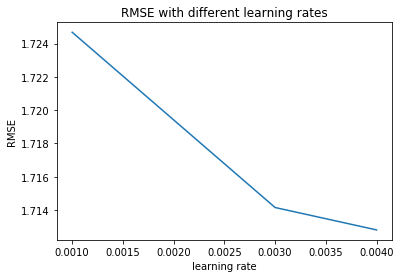

In [211]:
d = df_results[df_results['n_epochs']==50]
data = d[['alpha', 'RMSE_test']]
plt.plot([0.001,0.003,0.004], [1.724677, 1.714151, 1.712805])
plt.title('RMSE with different learning rates')
plt.xlabel('learning rate')
plt.ylabel('RMSE')
plt.show()

In [4]:
df_results_b = pd.read_pickle('Results/' + 'df_results_svd')
df_results_b.sort_values('RMSE_test')

,RMSE_test,train_speed,nolf,n_epochs,alpha,alpha_b,use_bias,bu_reg,bi_reg,pu_reg,qi_reg,u_thres,i_thres,train_size,test_size,train_rmse
6,1.311972,1173.22,5,50,0.004,0.004,True,0.005,0.005,0.010,0.010,1,1,795272,88364,"[0.6246596789669256, 0.612616886735595, 0.6041..."
4,1.313160,1322.85,5,50,0.003,0.003,True,0.005,0.005,0.010,0.010,1,1,795272,88364,"[0.6258713932781838, 0.6156808155704458, 0.608..."
7,1.314319,1241.88,5,50,0.003,0.003,True,0,0,0.000,0.000,1,1,795272,88364,"[0.6258841108561224, 0.6156900891089366, 0.608..."
5,1.314979,1324.39,5,50,0.003,0.003,True,0.01,0.01,0.050,0.050,1,1,795272,88364,"[0.625878122576873, 0.6156927787600004, 0.6085..."
2,1.330818,1224.36,5,50,0.003,0.001,True,0.005,0.005,0.010,0.010,1,1,795272,88364,"[0.6295165887895271, 0.6238583479047624, 0.619..."
3,1.337847,1208.92,5,50,0.003,0.001,True,0.05,0.05,0.100,0.100,1,1,795272,88364,"[0.6295421469568135, 0.6239100139317504, 0.620..."
1,2.860312,1286.91,5,50,0.003,0.001,False,0,0,0.000,0.000,1,1,795272,88364,"[1.8586080489019707, 1.8578002094624173, 1.854..."
0,2.860927,1250.70,5,50,0.003,0.001,False,0,0,0.001,0.001,1,1,795272,88364,"[1.8586331916010113, 1.8579347936390103, 1.855..."


### Final Model Comparison
All other parameters remain the same

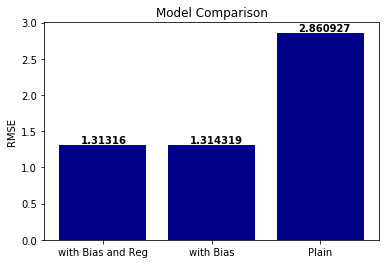

In [260]:
x = ['with Bias and Reg', 'with Bias', 'Plain']
y = [1.313160, 1.314319, 2.860927]

fig, ax = plt.subplots()
ind = np.arange(len(y))
width = 0.8
ax.bar(ind, y, width, color=['darkblue'])
ax.set_xticks(ind+width/500)
ax.set_xticklabels(x, minor=False)
ax.set_ylabel('RMSE')
ax.set_title('Model Comparison')
for i, v in enumerate(y):
    ax.text(i -0.2, v + 0.02, str(v), fontweight='bold')
plt.show()

### Best model train RMSE
Could enlarge training to 100 iterations as no convergence yet, however might overfit

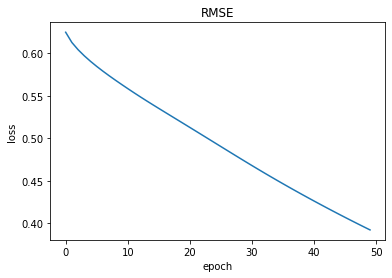

In [274]:
best = df_results_b.iloc[6]
plot_rmse(best['train_rmse'], best['n_epochs'])

# Appendix

In [219]:
# from scipy.linalg import sqrtm

# X_train, X_test = train_test_split(df, test_size=0.10, shuffle=True, random_state=1234)
# X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=1234)

# def create_utility_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):
#     """
#         :param data:      Array-like, 2D, nx3
#         :param formatizer:pass the formatizer
#         :return:          utility matrix (n x m), n=users, m=items
#     """
        
#     itemField = formatizer['item']
#     userField = formatizer['user']
#     valueField = formatizer['value']
    
#     userList = data.iloc[:,userField].tolist()
#     itemList = data.iloc[:,itemField].tolist()
#     valueList = data.iloc[:,valueField].tolist()
    
#     users = list(set(data.iloc[:,userField]))
#     items = list(set(data.iloc[:,itemField]))
    
#     users_index = {users[i]: i for i in range(len(users))}
#     pd_dict = {item: [np.nan for i in range(len(users))] for item in items}
    
#     for i in range(0,len(data)):
#         item = itemList[i]
#         user = userList[i]
#         value = valueList[i]
        
#     pd_dict[item][users_index[user]] = value
#     X = pd.DataFrame(pd_dict)
#     X.index = users
        
#     itemcols = list(X.columns)
#     items_index = {itemcols[i]: i for i in range(len(itemcols))}
#     # users_index gives us a mapping of user_id to index of user
#     # items_index provides the same for items
#     return X, users_index, items_index

# X, users_index, items_index = create_utility_matrix(X_train)


In [220]:
# n_users = df.user.unique().shape[0]
# n_items = df.item.unique().shape[0]

# ratings_train = np.zeros((n_users, n_items))
# for row in X_train.itertuples():
#         ratings_train[row[5], row[4]] = row[3]

# pd.DataFrame(ratings_train).head()
# # sparse.csr_matrix((X_train['rating']),shape(n_users, n_items))

In [221]:
# user_item_combos = 0
# for epoch in range(n_epochs):
#     for u in range(ratings_train.shape[0]): #users
#         for i in range(ratings_train.shape[1]): #items
#             r_ui = ratings_train[u,i]
            
#             if  r_ui != 0:
#                 user_item_combos += 1
#                 error = r_ui - np.dot(p[u], q[i])
                
#                 p[u] += alpha *(error * q[i])
#                 q[i] += alpha * (error * p[u])
                
#                 total_error += np.square(error)
# #         print(total_error)
#     rmse = math.sqrt(total_error)
#     print('epoch: ', epoch)#, '  rmse: ', rmse)
#     print(user_item_combos, X_train['rating'].shape[0])

In [218]:
# b_user[u] += alpha_b * (error - bu_reg * b_user[u])
# b_item[i] += alpha_b * (error - bi_reg * b_item[i])
            
# p[u] += alpha * (error * q[i] - pu_reg * p[u])
# q[i] += alpha * (error * p[u] - qi_reg * q[i])